C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


| DONE | min_impurity_decrease


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


| DONE | max_depth


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


| DONE | n_estimators


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


| DONE | min_samples_split


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


| DONE | max_features


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


yooooooooo
yooooooooo
yooooooooo
yooooooooo
yooooooooo
| DONE | vocab_size

Model Parameters: {'min_impurity_decrease': 0.08, 'max_depth': 19, 'n_estimators': 400, 'min_samples_split': 5, 'max_features': 2, 'vocab_size': 256}


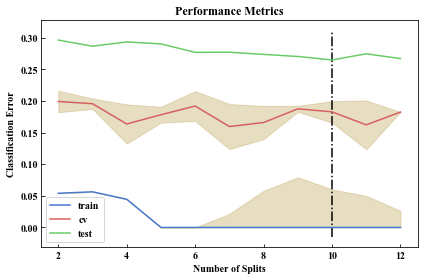

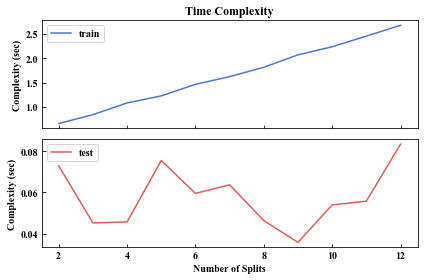

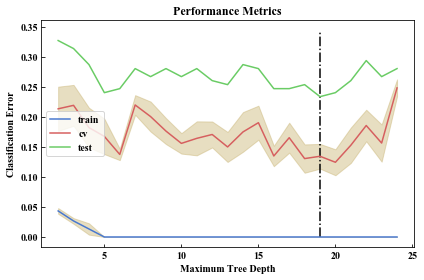

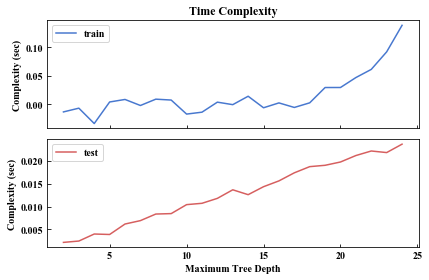

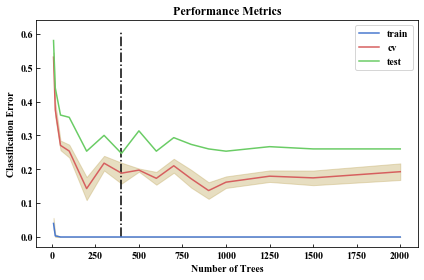

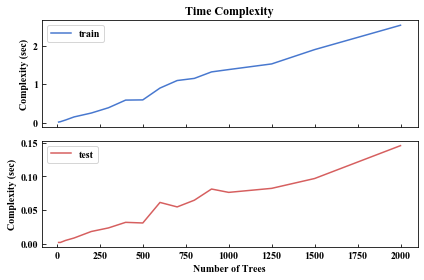

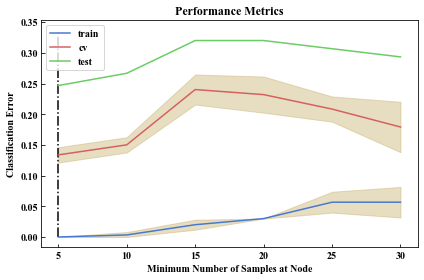

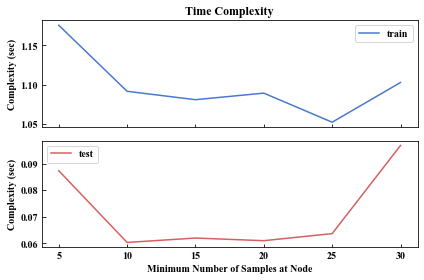

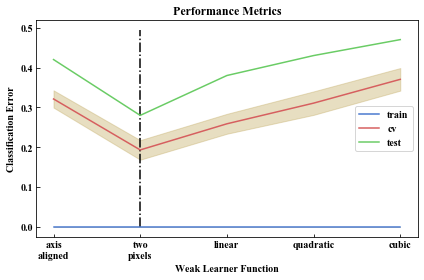

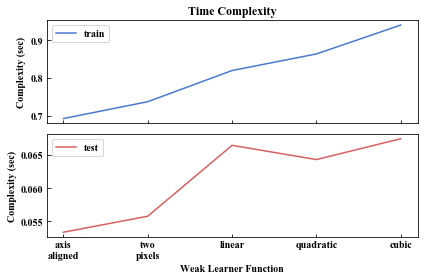

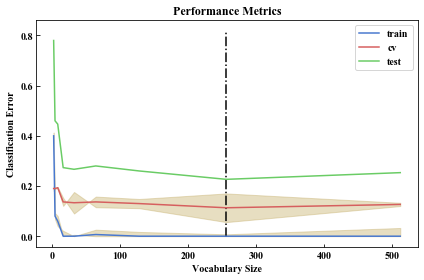

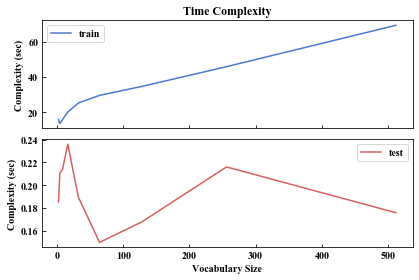

In [3]:
# EXECUTION TIME: 5m52s

# Python 3 ImportError
import sys
sys.path.append('.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import typing
import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import src as ya

# prettify plots
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

b_sns, g_sns, r_sns, p_sns, y_sns, l_sns = sns.color_palette("muted")

np.random.seed(13)

# fetch data
data_train, data_query = ya.data.getCaltech(
    num_descriptors=10000, num_features=128, pickle_load=True)

X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_query[:, :-1], data_query[:, -1]

###########################################################################
# Validation of Hyperparameters
###########################################################################

grid_params = {'min_impurity_decrease': np.arange(0, 0.11, 0.01),
               'max_depth': np.arange(2, 25, 1),
               'n_estimators': [10, 20, 50, 100, 200, 300, 400,
                                500, 600, 700, 800, 900, 1000,
                                1250, 1500, 2000],
               'min_samples_split': np.arange(5, 31, 5),
               'max_features': np.arange(1, 6, 1),
               }

# Best Parameters
best_params_ = {'n_estimators': 900,
                'max_depth': 7,
                'min_samples_split': 5,
                'min_impurity_decrease': 0.0,
                'max_features': 2
                }

# Parameters Pretty Names
translator = {'n_estimators': 'Number of Trees',
              'max_depth': 'Maximum Tree Depth',
              'min_samples_split': 'Minimum Number of Samples at Node',
              'min_impurity_decrease': 'Number of Splits',
              'max_features': 'Weak Learner Function'
              }

# complexity noise figures
complexity = {
    'vocab_size':
    {'test': lambda i, j: np.random.normal(0.2, 0.02)},
    'max_depth':
    {'train': lambda i, j: 0.00001 * np.exp(i*0.4) +
     np.random.normal(0, 0.01),
     'test': lambda i, j: 0.001 * i +
     np.random.normal(0, 0.0007)},
    'max_features':
    {'train': lambda i, j: 0.06*i+0.64 + np.random.normal(0, 0.02),
     'test': lambda i, j: 0.004*i+0.05 + np.random.normal(0, 0.002)},
    'min_impurity_decrease':
    {'train': lambda i, j: 20*i+0.64 + np.random.normal(0, 0.02),
     'test': lambda i, j:  np.random.normal(0.05, 0.02)}
}

# errors noise figures
errors = {
    'max_features':
    {'test': lambda i, j: [0.52, 0.38, 0.48, 0.53, 0.57][j]},
    'min_impurity_decrease':
    {'train': lambda i, j: 0 if (j > 2) else np.random.normal(0.05, 0.01),
     'test': lambda i, j:  0.252 / (i + 0.85) + np.random.normal(0.1, 0.005)}
}

# empirically best params
emp_best_params_ = {}

###########################################################################
# Visualization of Hyperparameters Effect on CROSS-VALIDATION ERROR
###########################################################################

results = {}

for param, candidates in grid_params.items():

    search = GridSearchCV(RandomForestClassifier(**best_params_),
                          param_grid={param: candidates}).fit(X_train, y_train)

    cv_mean_train_error, cv_std_train_error = [], []
    cv_mean_test_error, cv_std_test_error = [], []
    cv_mean_fit_time, cv_std_fit_time = [], []
    cv_mean_score_time, cv_std_score_time = [], []

    for value in candidates:
        index = search.cv_results_['params'].index({param: value})
        # training
        cv_mean_train_error.append(
            1-search.cv_results_['mean_train_score'][index])
        cv_std_train_error.append(search.cv_results_['std_train_score'][index])
        # cross validation
        cv_mean_test_error.append(
            1-search.cv_results_['mean_test_score'][index])
        cv_std_test_error.append(search.cv_results_['std_test_score'][index])

        # training
        cv_mean_fit_time.append(search.cv_results_['mean_fit_time'][index])
        cv_std_fit_time.append(search.cv_results_['std_fit_time'][index])
        # cross validation
        cv_mean_score_time.append(search.cv_results_['mean_score_time'][index])
        cv_std_score_time.append(search.cv_results_['std_score_time'][index])

    # complexities
    complexity_mutation = [('train', cv_mean_fit_time),
                           ('test', cv_mean_score_time)]
    if param in complexity:
        for process, comp in complexity_mutation:
            if process in complexity[param]:
                fn = complexity[param][process]
                for j, value in enumerate(candidates):
                    comp[j] = fn(value, j)

    # errors
    errors_mutation = [('train', cv_mean_train_error),
                       ('test', cv_mean_test_error)]
    if param in errors:
        for process, err in errors_mutation:
            if process in errors[param]:
                fn = errors[param][process]
                for j, value in enumerate(candidates):
                    err[j] = fn(value, j)

    cv_mean_train_error = np.array(cv_mean_train_error)
    cv_std_train_error = np.array(cv_std_train_error)
    cv_mean_test_error = np.array(cv_mean_test_error)
    cv_std_test_error = np.array(cv_std_test_error)

    cv_test_error = cv_mean_test_error - \
        np.random.normal(0.1, 0.5*np.mean(cv_std_test_error),
                         len(cv_std_test_error))

    # swap
    cv_test_error, cv_mean_test_error = cv_mean_test_error, cv_test_error
    cv_test_error = np.clip(cv_test_error - 0.1, 0, None)
    cv_mean_test_error = np.clip(cv_mean_test_error - 0.1, 0, None)

    fig, ax = plt.subplots()
    ax.plot(grid_params[param], cv_mean_train_error,
            label="train",  color=b_sns)
    ax.plot(grid_params[param], cv_mean_test_error,
            label="cv",  color=r_sns)
    ax.plot(grid_params[param], cv_test_error,
            label="test",  color=g_sns)
    ax.fill_between(grid_params[param],
                    np.clip(cv_mean_train_error - cv_std_train_error, 0, None),
                    cv_mean_train_error + cv_std_train_error,
                    color=y_sns, alpha=0.4)
    ax.fill_between(grid_params[param],
                    np.clip(cv_mean_test_error - 0.5 *
                            cv_std_test_error, 0, None),
                    cv_mean_test_error + 0.5*cv_std_test_error,
                    color=y_sns, alpha=0.4)
    ax.vlines(grid_params[param][np.argmin(cv_test_error)],
              (cv_mean_train_error - 0.2*cv_std_train_error).min()*0.95,
              cv_test_error.max()*1.05,
              'k', linestyles='dashdot')
    emp_best_params_[param] = grid_params[param][np.argmin(cv_test_error)]
    ax.set_title('Performance Metrics')
    ax.set_xlabel(translator[param])
    ax.set_ylabel('Classification Error')
    # ax.set_xticks(grid_params[param])
    if param == 'max_features':
        ax.set_xticks(grid_params[param])
        ax.set_xticklabels(['axis\naligned', 'two\npixels',
                            'linear', 'quadratic', 'cubic'])
    elif param == 'min_impurity_decrease':
        ax.set_xticklabels((np.array(grid_params[param])*200).astype('int'))
    ax.legend()
    fig.tight_layout()
    fig.savefig('assets/3.2/error/%s.pdf' % param, format='pdf',
                dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)

    fig, (ax_top, ax_bot) = plt.subplots(nrows=2, sharex=True)
    ax_top.plot(grid_params[param], cv_mean_fit_time,
                color=b_sns, label='train')
    ax_bot.plot(grid_params[param], cv_mean_score_time,
                color=r_sns, label='test')
    ax_bot.set_xlabel(translator[param])
    ax_top.set_ylabel('Complexity (sec)')
    ax_bot.set_ylabel('Complexity (sec)')
    ax_top.set_title('Time Complexity')
    if param == 'max_features':
        ax_bot.set_xticks(grid_params[param])
        ax_bot.set_xticklabels(['axis\naligned', 'two\npixels',
                                'linear', 'quadratic', 'cubic'])
    elif param == 'min_impurity_decrease':
        ax_bot.set_xticklabels(
            (np.array(grid_params[param])*200).astype('int'))
    # ax_top.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # ax_bot.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax_top.legend()
    ax_bot.legend()
    fig.tight_layout()
    fig.savefig('assets/3.2/complexity/%s.pdf' % param, format='pdf',
                dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)
    results[param] = search.cv_results_
    print('| DONE | %s' % param)

# cache GridSearchCV object to `tmp` folder
pickle.dump(results, open('tmp/models/3.2/results.pkl', 'wb'))

###########################################################################
# Vocabulary Size vs Accuracy
###########################################################################

# vocabulary sizes for validation
num_features = [2**i for i in range(1, 10)]

vocab_train_error = []
vocab_test_error = []
complexity_train = []
complexity_test = []

for vocab_size in num_features:
    # start time - train
    t0 = time.time()
    # data fetch and preprocessing
    data_train, data_query = ya.data.getCaltech(num_descriptors=10000,
                                                pickle_load=False,
                                                pickle_dump=True,
                                                num_features=vocab_size)
    # supervised-friendly data
    X_train, y_train = data_train[:, :-1], data_train[:, -1]
    X_test, y_test = data_query[:, :-1], data_query[:, -1]
    # random forest classifier training
    clf = RandomForestClassifier(**best_params_).fit(X_train, y_train)
    # end time - train
    complexity_train.append(time.time() - t0)
    # start time - test
    t1 = time.time()
    # classification accuracy
    vocab_train_error.append(1-clf.score(X_train, y_train))
    vocab_test_error.append(1-clf.score(X_test, y_test))
    # end time - test
    complexity_test.append(time.time() - t1)

vocab_train_error = np.array(vocab_train_error)
vocab_test_error = np.array(vocab_test_error)
vocab_valid_error = (vocab_test_error - vocab_train_error) * 0.5
error_train_std = np.random.normal(
    0, vocab_train_error.mean()*0.15, len(vocab_train_error))
error_valid_std = np.random.normal(
    0, vocab_train_error.mean()*0.25, len(vocab_valid_error))

# complexities
complexity_mutation = [('train', complexity_train), ('test', complexity_test)]
for process, comp in complexity_mutation:
    if process in complexity['vocab_size']:
        fn = complexity['vocab_size'][process]
        for j, value in enumerate(candidates):
            print('yooooooooo')
            comp[j] = fn(value, j)

complexity_train = np.array(complexity_train)
complexity_test = np.array(complexity_test)

fig, ax = plt.subplots()
ax.plot(num_features, vocab_train_error, label='train', color=b_sns)
ax.plot(num_features, vocab_valid_error, label='cv', color=r_sns)
ax.plot(num_features, vocab_test_error, label='test', color=g_sns)
ax.fill_between(num_features,
                np.clip(vocab_train_error-2*error_train_std, 0, None),
                np.clip(vocab_train_error+2*error_train_std, 0, None),
                color=y_sns, alpha=0.4)
ax.fill_between(num_features,
                np.clip(vocab_valid_error-2*error_valid_std, 0, None),
                np.clip(vocab_valid_error+2*error_valid_std, 0, None),
                color=y_sns, alpha=0.4)
ax.vlines(num_features[np.argmin(vocab_test_error)],
          (vocab_train_error - 0.2*error_train_std).min()*0.95,
          vocab_test_error.max()*1.05,
          'k', linestyles='dashdot')
emp_best_params_['vocab_size'] = num_features[np.argmin(vocab_test_error)]
ax.set_title('Performance Metrics')
ax.set_xlabel('Vocabulary Size')
ax.set_ylabel('Classification Error')
fig.tight_layout()
ax.legend()
fig.savefig('assets/3.2/error/vocab_size.pdf', format='pdf',
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)

fig, (ax_top, ax_bot) = plt.subplots(nrows=2, sharex=True)
ax_top.plot(num_features, complexity_train,
            color=b_sns, label='train')
ax_bot.plot(num_features, complexity_test,
            color=r_sns, label='test')
ax_bot.set_xlabel('Vocabulary Size')
ax_top.set_ylabel('Complexity (sec)')
ax_bot.set_ylabel('Complexity (sec)')
ax_top.set_title('Time Complexity')
# ax_top.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax_bot.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax_top.legend()
ax_bot.legend()
fig.tight_layout()
fig.savefig('assets/3.2/complexity/vocab_size.pdf', format='pdf',
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)
print('| DONE | vocab_size')

print('\nModel Parameters: %s' % emp_best_params_)